In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/global/homes/l/lbigwood/S4Mock/')
from corr_func_tools import calc_wtheta, create_axes
import S4Mock_io
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table,vstack,join
import glob
import astropy.io.fits as fits
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 
nbins=30
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fassign = Table(S4Mock_io.read_fassign_mock())

In [4]:
favail = Table(S4Mock_io.read_favail_mock())

In [5]:
mask,idx = np.unique(fassign['TARGETID'].data,return_index=True)
fassign = fassign[idx]

mask,idx,counts = np.unique(favail['TARGETID'].data,return_index=True,return_counts=True)
favail = favail[idx]
favail['COUNT']= counts
favail['WEIGHT']=1/counts

In [6]:
init_ledger = S4Mock_io.read_init_ledger()

In [7]:
init_ledger = init_ledger[((init_ledger['SV3_BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0)]

In [8]:
assigned_ledger = init_ledger[np.in1d(init_ledger['TARGETID'],fassign['TARGETID'])]
avail_ledger = init_ledger[np.in1d(init_ledger['TARGETID'],favail['TARGETID'])]

In [9]:
assigned_ledger=Table(assigned_ledger)

In [10]:
weight_assigned_ledger = join(assigned_ledger, favail,keys='TARGETID', join_type='left')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


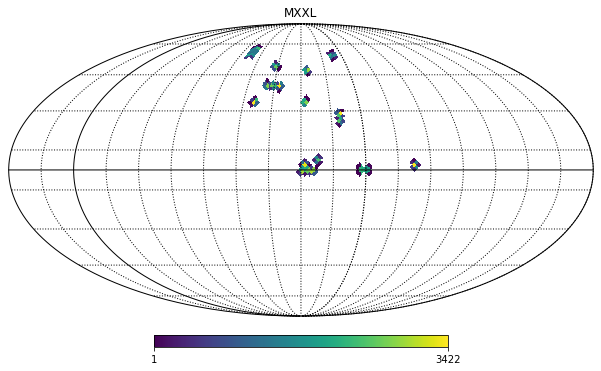

In [14]:
import geometry
import healpy as hp
target_pixel_density = geometry.targ_hpmap(weight_assigned_ledger)
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='MXXL')
hp.graticule(dpar=5, dmer=5)

In [15]:
sv3_rand = S4Mock_io.read_sv3_randoms(number=1)

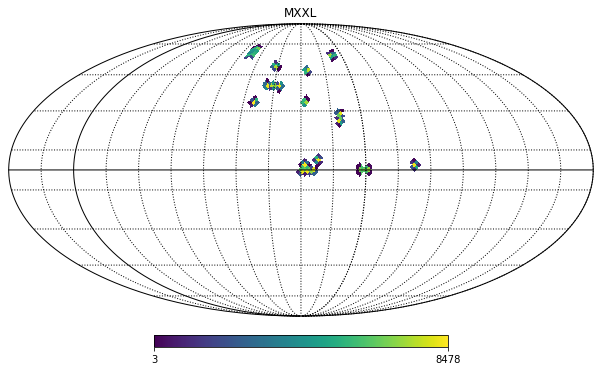

In [16]:
import geometry
import healpy as hp
target_pixel_density = geometry.targ_hpmap(sv3_rand)
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='MXXL')
hp.graticule(dpar=5, dmer=5)

In [18]:
wtheta_mock_fba = calc_wtheta(assigned_ledger['RA'],assigned_ledger['DEC'],sv3_rand['RA'],sv3_rand['DEC'])

/global/homes/l/lbigwood/.local/lib/python3.8/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


In [56]:
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

RA = weight_assigned_ledger['RA'].data
DEC = weight_assigned_ledger['DEC'].data
N = len(RA)


rand_RA = sv3_rand['RA']
rand_DEC = sv3_rand['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,weights1=weight_assigned_ledger['WEIGHT'].data,weight_type='pair_product')


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC,weights1=weight_assigned_ledger['WEIGHT'].data,weight_type='pair_product')


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)


# All the pair counts are done, get the angular correlation function
wtheta_mock_fba_corr = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

In [57]:
DD_counts

array([(1.00000000e-03, 1.35935639e-03, 0.,      1120, 0.),
       (1.35935639e-03, 1.84784980e-03, 0.,      1714, 0.),
       (1.84784980e-03, 2.51188643e-03, 0.,      2738, 0.),
       (2.51188643e-03, 3.41454887e-03, 0.,      4706, 0.),
       (3.41454887e-03, 4.64158883e-03, 0.,      7456, 0.),
       (4.64158883e-03, 6.30957344e-03, 0.,     12434, 0.),
       (6.30957344e-03, 8.57695899e-03, 0.,     21012, 0.),
       (8.57695899e-03, 1.16591440e-02, 0.,     35986, 0.),
       (1.16591440e-02, 1.58489319e-02, 0.,     62450, 0.),
       (1.58489319e-02, 2.15443469e-02, 0.,    108778, 0.),
       (2.15443469e-02, 2.92864456e-02, 0.,    191968, 0.),
       (2.92864456e-02, 3.98107171e-02, 0.,    343710, 0.),
       (3.98107171e-02, 5.41169527e-02, 0.,    616758, 0.),
       (5.41169527e-02, 7.35642254e-02, 0.,   1111838, 0.),
       (7.35642254e-02, 1.00000000e-01, 0.,   1999370, 0.),
       (1.00000000e-01, 1.35935639e-01, 0.,   3602492, 0.),
       (1.35935639e-01, 1.84784980e-01, 

In [20]:
wtheta_mock_init = calc_wtheta(init_ledger['RA'],init_ledger['DEC'],sv3_rand['RA'],sv3_rand['DEC'])

In [58]:
nbins=30

x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_clustering.dat.fits')
dat = x[1].data


x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_0_full.ran.fits')
ran = x[1].data 

fba_wtheta = calc_wtheta(dat['RA'],dat['DEC'],ran['RA'],ran['DEC'],nbins=nbins)

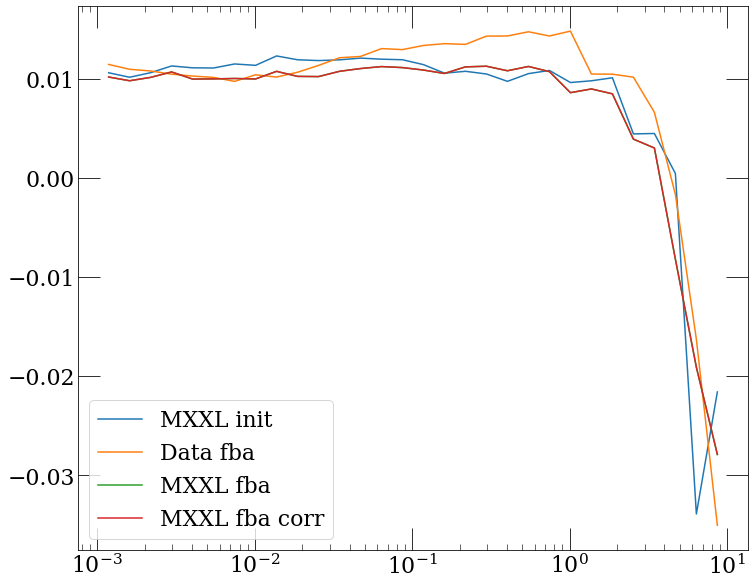

In [60]:
plt.figure(figsize=(12,10))
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)

#mxxl all
x_axis1,y_axis1 = create_axes(wtheta_mock_init)
plt.plot(x_axis1,y_axis1,label='MXXL init')

x_axis1,y_axis1 = create_axes(fba_wtheta)
plt.plot(x_axis1,y_axis1,label='Data fba')

x_axis1,y_axis1 = create_axes(wtheta_mock_fba)
plt.plot(x_axis1,y_axis1,label='MXXL fba')

x_axis1,y_axis1 = create_axes(wtheta_mock_fba_corr)
plt.plot(x_axis1,y_axis1,label='MXXL fba corr')

plt.xscale('log')
plt.legend()

In [24]:
wtheta_mock_fba

array([ 2.24705252e+00,  1.69292111e+00,  1.37001326e+00,  1.12941712e+00,
        8.24140458e-01,  6.45956037e-01,  5.07303001e-01,  3.94981659e-01,
        3.32649466e-01,  2.47934790e-01,  1.93560462e-01,  1.59266730e-01,
        1.27800057e-01,  1.01781248e-01,  7.88839956e-02,  6.03308388e-02,
        4.56996344e-02,  3.80047628e-02,  2.98978634e-02,  2.24386290e-02,
        1.82568357e-02,  1.36211263e-02,  8.54884137e-03,  6.97825293e-03,
        5.15932273e-03,  1.86792905e-03,  1.12929730e-03, -2.37315844e-03,
       -4.33414853e-03, -4.95361693e-03])

In [25]:
wtheta_mock_fba_corr

array([ 2.24705252e+00,  1.69292111e+00,  1.37001326e+00,  1.12941712e+00,
        8.24140458e-01,  6.45956037e-01,  5.07303001e-01,  3.94981659e-01,
        3.32649466e-01,  2.47934790e-01,  1.93560462e-01,  1.59266730e-01,
        1.27800057e-01,  1.01781248e-01,  7.88839956e-02,  6.03308388e-02,
        4.56996344e-02,  3.80047628e-02,  2.98978634e-02,  2.24386290e-02,
        1.82568357e-02,  1.36211263e-02,  8.54884137e-03,  6.97825293e-03,
        5.15932273e-03,  1.86792905e-03,  1.12929730e-03, -2.37315844e-03,
       -4.33414853e-03, -4.95361693e-03])